In [19]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from scipy.stats import pearsonr
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

# Load data

In [20]:
all_poms_before_sampling = pd.read_csv("data/all_poms_before_sampling.csv")
all_repos_before_sampling = pd.read_csv("data/all_repos_before_sampling.csv")

C:\Users\jacob\AppData\Local\Temp\ipykernel_12260\2805030735.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  all_poms_before_sampling = pd.read_csv("data/all_poms_before_sampling.csv")
C:\Users\jacob\AppData\Local\Temp\ipykernel_12260\2805030735.py:2: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  all_repos_before_sampling = pd.read_csv("data/all_repos_before_sampling.csv")


## Random Sampling and removing duplicates

In [21]:
all_poms = all_poms_before_sampling.copy()
l_all_poms = len(all_poms)

random_seed = 42
np.random.seed(random_seed)

# Shuffle the DataFrame randomly
all_poms = all_poms.sample(frac=1).reset_index(drop=True)

# Remove duplicates from poms to only mantain one version of each package
all_poms = all_poms.drop_duplicates(subset=['groupId', 'artifactId'])

# Reset the index of the deduplicated DataFrame
all_poms.reset_index(drop=True, inplace=True)

print("all_poms: " + str(l_all_poms) + " -> " + str(len(all_poms)))

# only take rows that are later than or in 2016 
all_poms['releaseDate'] = pd.to_datetime(all_poms['releaseDate'])
all_poms = all_poms[all_poms['releaseDate'].dt.year >= 2016]

# Save the DataFrame to a CSV file
all_poms.to_csv('data/all_poms.csv', index=False)

all_poms: 934266 -> 199188


In [22]:
all_repos = all_repos_before_sampling.copy()
l_all_repos = len(all_repos)

# Drop duplicates from repos
all_repos = all_repos.drop_duplicates(subset=['id', 'pomId', 'name', 'url'])
all_repos = all_repos[all_repos['pomId'].isin(all_poms['id'])]

print("all_repos: " + str(l_all_repos) + " -> " + str(len(all_repos)))

# Save the DataFrame to a CSV file
all_repos.to_csv('data/all_repos.csv', index=False)

all_repos: 157387 -> 16781


In [23]:
# <erge poms and repos and name the id of left id_pom and id_repo
all_poms_repos = pd.merge(all_poms, all_repos, left_on='id', right_on='pomId', how='inner')
all_poms_repos = all_poms_repos.rename(columns={'id_x': 'id_pom', 'id_y': 'id_repo'})
all_poms_repos = all_poms_repos.rename(columns={'url_x': 'url_pom', 'url_y': 'url_repo'})

print("all_poms_repos: " + str(len(all_poms_repos)))

all_poms_repos: 16781


# Showing the distribution of the data

   releaseDate  count
0         2016  23701
1         2017  21406
2         2018  24571
3         2019  31089
4         2020  19561
5         2021  21559
6         2022  23481
7         2023  33815


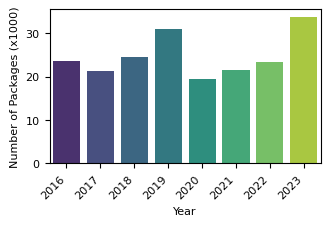

In [24]:
df = all_poms.copy()
df['releaseDate'] = pd.to_datetime(df['releaseDate'])

# Group by year and count the rows
yearly_counts_v2 = df.groupby(df['releaseDate'].dt.year).size().reset_index(name='count')

# Display the result
print(yearly_counts_v2)

plt.figure(figsize=(3.5, 2))
ax = sns.barplot(x="releaseDate", y="count", data=yearly_counts_v2, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)))
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of Packages (x1000)', fontsize=8)
plt.show()

# Average packages with at least 1 repository per year

Poms this year: 23701, repos this year: 1199
Poms this year: 21406, repos this year: 1030
Poms this year: 24571, repos this year: 1142
Poms this year: 31089, repos this year: 1376
Poms this year: 19561, repos this year: 958
Poms this year: 21559, repos this year: 595
Poms this year: 23481, repos this year: 910
Poms this year: 33815, repos this year: 1067


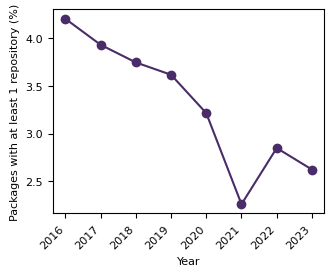

Pearsons correlation: -0.911 p-value:  0.001647937629582066


In [25]:
def calc_at_least_one_repo_percentage(repos, size):
    maven_central_urls = ['https://repo.maven.apache.org/maven2', 'https://repo1.maven.org/maven2', 'http://repo.maven.apache.org/maven2', 'http://repo1.maven.org/maven2']

    # Group by groupId and artifactId
    grouped = repos.groupby(['groupId', 'artifactId'])
    print(f"Poms this year: {size}, repos this year: {len(grouped)}")
    # Initialize count of packages with at least one non-central repo
    count = 0

    # Iterate over each group
    for _, group in grouped:
        # Create a mask for rows where 'url_repo' is not in 'maven_central_urls'
        mask = ~group['url_repo'].isin(maven_central_urls)
        
        # Apply the mask to 'package_group_data' and select 'url_repo' column
        filtered_repos = group.loc[mask, 'url_repo']
           
        # Count the number of unique repositories
        unique_repos = filtered_repos.nunique()
        
        # If there is more than one unique repo, increment the count
        if unique_repos >= 1:
            count += 1
            
    percentage = (count / size) * 100
    return percentage

# group all_poms_repos per year
all_poms_repos['year'] = pd.to_datetime(all_poms_repos['releaseDate']).dt.year
grouped = all_poms_repos.groupby('year')

# group all poms per year
all_poms['year'] = pd.to_datetime(all_poms['releaseDate']).dt.year
grouped_poms = all_poms.groupby('year')

years = {}

# calculate percentage of packages with at least 1 repo per year
for year, group in grouped:
    # get size of poms per year
    size = len(grouped_poms.get_group(year))
    percentage = calc_at_least_one_repo_percentage(group, size)
    years[year] = percentage
    
# Plotting
plt.figure(figsize=(3.5, 3))
plt.subplots_adjust(bottom=0.2)
plt.plot(list(years.keys()), years.values(), label='Combined', color='#492c68', marker='o')
plt.xticks(list(years.keys()), rotation=45, horizontalalignment='right', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Packages with at least 1 repository (%)', fontsize=8)
plt.show()

corr, p_val = pearsonr(list(years.keys()), list(years.values()))
print('Pearsons correlation: %.3f' % corr, "p-value: ", p_val)

{2: 0.7169286535497507, 1: 1.8480492813141685, 3: 0.30374078109075575, 4: 0.12199836331413827, 7: 0.03413945969284527, 5: 0.09940607381152006, 6: 0.08183429308726146, 9: 0.04116817198254871, 8: 0.009036915801047278, 10: 0.03464151057068123}


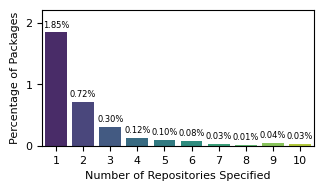

In [26]:
def calc_and_plot_exact_repo_percentage(repos):
    maven_central_urls = ['https://repo.maven.apache.org/maven2', 'https://repo1.maven.org/maven2', 'http://repo.maven.apache.org/maven2', 'http://repo1.maven.org/maven2']

    grouped = repos.groupby(['groupId', 'artifactId'])

    repo_counts = {}

    for _, group in grouped:
        mask = ~group['url_repo'].isin(maven_central_urls)
        filtered_repos = group.loc[mask, 'url_repo']
        unique_repos = filtered_repos.nunique()

        if unique_repos in repo_counts:
            repo_counts[unique_repos] += 1
        else:
            repo_counts[unique_repos] = 1

    total_packages = len(all_poms)
    percentage_repos = {num_repos: (count / total_packages) * 100 for num_repos, count in repo_counts.items()}

    plt.figure(figsize=(3.5, 2))
    plt.subplots_adjust(bottom=0.2)

    # only keep 0 till 10
    percentage_repos = {k: v for k, v in percentage_repos.items() if k <= 10}
    percentage_repos.pop(0, None)
    print(percentage_repos)

    bars = sns.barplot(x=list(percentage_repos.keys()), y=list(percentage_repos.values()), palette='viridis')
    plt.ylim(0, 1.2 * max(percentage_repos.values()))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}%', ha='center', va='bottom', fontsize=6)

    plt.xlabel('Number of Repositories Specified', fontsize=8)
    plt.ylabel('Percentage of Packages', fontsize=8)

    plt.xticks(range(10))  
    ax = plt.gca()  
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x + 1)))
    plt.show()

calc_and_plot_exact_repo_percentage(all_poms_repos)

In [27]:
percentage_at_least_one_repo = calc_at_least_one_repo_percentage(all_poms_repos, len(all_poms))
print(f"Percentage of packages with at least one repo: {percentage_at_least_one_repo}")

Poms this year: 199183, repos this year: 8277
Percentage of packages with at least one repo: 3.291947605970389


# Do repository ids commonly change when new versions of the same package are released?

In [28]:
def analyze_id_variations(repos):
    # Group by groupId and artifactId
    grouped = repos.groupby(['groupId', 'artifactId', 'url_y'])
    changes_count = 0
    total_groups = 0

    for _, group in grouped:
        total_groups += 1
        # Check if there are variations in ID across different versions
        if group['id_y'].nunique() > 1:
            changes_count += 1

    # Calculate the percentage of groups where IDs change
    if total_groups > 0:
        change_percentage = (changes_count / total_groups) * 100
    else:
        change_percentage = 0

    return change_percentage

merged_df = pd.merge(all_poms_before_sampling, all_repos_before_sampling, left_on='id', right_on='pomId', how='inner')

# Call the function and print the result
percentage_changes = analyze_id_variations(merged_df)
print(f"Percentage of groups with ID changes across versions: {percentage_changes}%")

Percentage of groups with ID changes across versions: 0.6806385270786407%


In [29]:
maven_errors = [
    {"issue": "Forbidden", "error_message": "Forbidden (403)"},
    {"issue": "Blocked Mirror", "error_message": "Blocked mirror"},
    {"issue": "Not found in Central", "error_message": "Could not find"},
    {"issue": "Non-resolvable parent POM", "error_message": "Non-resolvable parent POM"},
    {"issue": "Does not exist", "error_message": "does not exist"},
    {"issue": "Unknown packaging", "error_message": " Unknown packaging"},
    {"issue": "Connection refused", "error_message": "Connection refused"} 
]


def match_error_messages(dataset_msgs, predefined_errors):
    # Initialize a dictionary to count occurrences of each issue
    issue_counts = {error['issue']: 0 for error in predefined_errors}

    for dataset_msg in dataset_msgs:
        for error in predefined_errors:
            if error['error_message'].lower() in dataset_msg.lower():
                issue_counts[error['issue']] += 1

    return issue_counts


1741


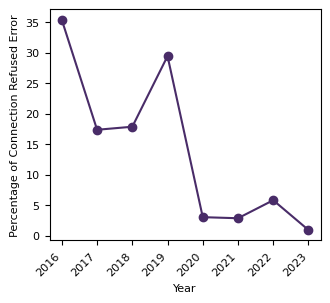

In [30]:
error_all_poms = all_poms.copy()
error_all_poms['year'] = pd.to_datetime(error_all_poms['releaseDate']).dt.year
error_all_poms.dropna(subset=['mavenErrorMessage'], inplace=True)

print(len(error_all_poms))
grouped =  error_all_poms.groupby('year')


# calculate percentage of error types for each year
issues_per_year = {}

for year, group in grouped:
    error_messages = group['mavenErrorMessage'].dropna()
    issue_counts = match_error_messages(error_messages, maven_errors)
    total_errors = sum(issue_counts.values())
    
    for issue in issue_counts:
        issue_counts[issue] = issue_counts[issue] / total_errors * 100 if total_errors > 0 else 0
    issues_per_year[year] = issue_counts
    
plot_issues = ['Connection refused']

# plot the results
plt.figure(figsize=(3.5, 3))

for issue in plot_issues:
    years = list(issues_per_year.keys())
    percentages = [issues_per_year[year][issue] for year in years]
    plt.plot(years, percentages, marker='o', color='#492c68', label=issue)   
    
plt.xticks(years, fontsize=8)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Percentage of Connection Refused Error', fontsize=8)
plt.show()

In [31]:
# Calculate the percentage of packages that have an error
total_packages = len(all_poms)
poms_with_errors = all_poms.dropna(subset=['mavenErrorMessage'], inplace=False)
packages_with_errors = len(poms_with_errors)
percentage_with_errors = (packages_with_errors / total_packages) * 100

print(f"Percentage of packages that have an error: {percentage_with_errors}%")

# Filter the DataFrame to include only rows where repositoriesAmount is greater than or equal to 1
packages_with_repos = all_poms[all_poms['repositoriesAmount'] >= 1].copy()

# Count the number of packages that have one or more repositories
num_packages_with_repos = len(packages_with_repos)

# Filter the DataFrame to include only rows where mavenErrorMessage is not null
packages_with_repos_and_errors = packages_with_repos.dropna(subset=['mavenErrorMessage'])

# Count the number of packages that have one or more repositories and have an error
num_packages_with_repos_and_errors = len(packages_with_repos_and_errors)

percentage_packages_with_repos_with_error =  num_packages_with_repos_and_errors / num_packages_with_repos * 100

print(f"Percentage of packages with repositories that have an error: {percentage_packages_with_repos_with_error}%")

# Filter the DataFrame to include only rows where repositoriesAmount is 0
packages_with_no_repos = all_poms[all_poms['repositoriesAmount'] == 0].copy()

# Filter the DataFrame to include only rows where repositoriesAmount is greater than or equal to 1
packages_with_repos = all_poms[all_poms['repositoriesAmount'] >= 1].copy()

# Calculate the percentage of errors for packages with no repositories
packages_with_no_repos['has_error'] = packages_with_no_repos['mavenErrorMessage'].notna()
percentage_errors_no_repos = packages_with_no_repos['has_error'].mean()
print(f"Percentage of packages without repositories that have an error: {percentage_errors_no_repos*100}%")

# Calculate the percentage of errors for packages with repositories
packages_with_repos['has_error'] = packages_with_repos['mavenErrorMessage'].notna()
percentage_errors_with_repos = packages_with_repos['has_error'].mean()

# Perform the t-test
t_stat, p_val = stats.ttest_ind(packages_with_no_repos['has_error'], packages_with_repos['has_error'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

Percentage of packages that have an error: 0.8740705783124062%
Percentage of packages with repositories that have an error: 0.8861538461538463%
Percentage of packages without repositories that have an error: 0.8735704378320379%
T-statistic: -0.1193421947180227
P-value: 0.9050043761588642


In [32]:
# Check for every row in in all_poms_repos whether the url_repo is in the error message
def check_url_in_error(row):
    if pd.isnull(row['mavenErrorMessage']):
        return np.nan
    elif row['url_repo'] in row['mavenErrorMessage']:
        return row['mavenErrorMessage']
    else:
        return np.nan

url_poms_repos = all_poms_repos.copy()
urls_with_errors = url_poms_repos.dropna(subset=['mavenErrorMessage', 'url_repo'], inplace=False).copy()
urls_with_errors['error_message_with_url'] = urls_with_errors.apply(check_url_in_error, axis=1)

# Percentage of errors containing repo url 
packages_with_url_as_error = urls_with_errors.dropna(subset=['error_message_with_url'], inplace=False)
deduplicated_packages = packages_with_url_as_error.drop_duplicates(subset=['groupId', 'artifactId', 'version'])

percentage_packages_with_url_as_error = len(deduplicated_packages) / len(all_poms_repos) * 100
print(f"Percentage of packages with repository URL in error message: {percentage_packages_with_url_as_error}%")

Percentage of packages with repository URL in error message: 0.15493713127942316%


# Testing availability of repository URLs

In [16]:
import requests

# Initialize a cache dictionary to store URL status codes
url_cache = {}

# Function to check URL availability and use cache
def check_url_availability(url):
    if url in url_cache:
        return url_cache[url]
    try:
        response = requests.get(url, timeout=5)
        status_code = response.status_code
        # if status code is redirect, get the status code of the redirected url
        if status_code == 301 or status_code == 302 or status_code == 307:
            status_code = requests.get(response.url, timeout=5).status_code
        url_cache[url] = status_code  # Cache the result        
        return status_code
    except requests.exceptions.RequestException:
        return None


In [17]:
# Strip right of / and get unique urls
all_poms_repos_copy = all_poms_repos.copy()
all_poms_repos_copy['url_repo'] = all_poms_repos_copy['url_repo'].str.rstrip('/')
unique_urls_repos = all_poms_repos_copy.drop_duplicates(subset=['url_repo'], keep='first').copy()

# Apply the function to each row and create a new 'stillAvailable' column
unique_urls_repos['stillAvailable'] = unique_urls_repos['url_repo'].apply(check_url_availability)

# Classify NaN values as timeouts
unique_urls_repos['stillAvailable'] = unique_urls_repos['stillAvailable'].fillna('Timeout')

# Calculate the percentage of 200 status codes
total_percentage_200 = (unique_urls_repos['stillAvailable'] == 200).mean() * 100

# Calculate the percentage of other status codes
total_percentage_other = 100 - total_percentage_200


# Step 5: Print the percentages
print(f'Total Percentage of 200 Status Codes: {total_percentage_200:.1f}%')
print(f'Total Percentage of Other Status Codes: {total_percentage_other:.1f}%')

Total Percentage of 200 Status Codes: 30.1%
Total Percentage of Other Status Codes: 69.9%


stillAvailable
200        30.129125
404        26.255380
Timeout    24.318508
400         8.249641
403         4.304161
401         3.515065
405         1.076040
502         0.573888
410         0.502152
503         0.502152
501         0.358680
500         0.071736
526         0.071736
203         0.071736
Name: proportion, dtype: float64


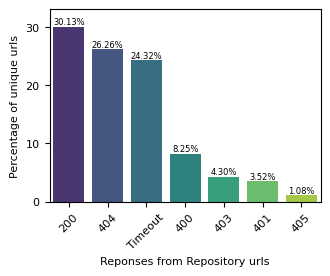

In [18]:

# Step 2: Group by 'stillAvailable' values and calculate percentages
unique_urls_repos['stillAvailable'] = unique_urls_repos['stillAvailable'].apply(lambda x: int(x) if x != 'Timeout' else x)
availability_counts = unique_urls_repos['stillAvailable'].value_counts(normalize=True) * 100

print(availability_counts)
availability_counts = availability_counts[availability_counts > 1]

# Step 3: Plot the percentages

# tilt ticks
plt.figure(figsize=(3.5, 2.5))

#bar plot with sns
bars = sns.barplot(x=availability_counts.index, y=availability_counts.values, palette='viridis')

plt.ylim(0, 1.1 * max(availability_counts.values))

ax = plt.gca()  # Get the current Axes instance

# percentage on top of bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}%', ha='center', va='bottom', fontsize=6)

plt.xlabel('Reponses from Repository urls', fontsize=8)
plt.ylabel('Percentage of unique urls', fontsize=8)
plt.xticks(fontsize=8, rotation=45, horizontalalignment='center')
plt.yticks(fontsize=8)
plt.show()

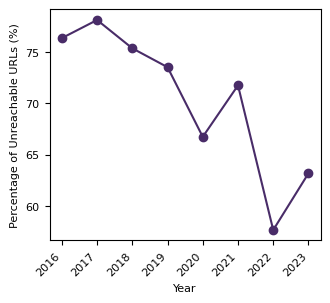

In [33]:
# Merge the dataframes on 'url_repo'
all_poms_repos_copy = all_poms_repos.copy()
merged_df = pd.merge(all_poms_repos_copy, unique_urls_repos[['url_repo', 'stillAvailable']], on='url_repo', how='left')

# Convert the 'releaseDate' column to datetime
merged_df['releaseDate'] = pd.to_datetime(merged_df['releaseDate'])

# Extract the year from 'releaseDate'
merged_df['year'] = merged_df['releaseDate'].dt.year

# Group by year
grouped = merged_df.groupby('year')

# Initialize a dictionary to store the percentage of unreachable URLs per year
unreachable_percentage_per_year = {}

# Calculate the percentage of unreachable URLs per year
for year, group in grouped:
    total_urls = len(group)
    unreachable_urls = len(group[group['stillAvailable'] != 200])
    unreachable_percentage = (unreachable_urls / total_urls) * 100 if total_urls > 0 else 0
    unreachable_percentage_per_year[year] = unreachable_percentage


# Plotting
plt.figure(figsize=(3.5, 3))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(list(unreachable_percentage_per_year.keys()), fontsize=8)
plt.xticks(rotation=45, horizontalalignment='right')
plt.plot(list(unreachable_percentage_per_year.keys()), list(unreachable_percentage_per_year.values()), marker='o', color='#492c68',)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Percentage of Unreachable URLs (%)', fontsize=8)
plt.show()

## Http vs Https

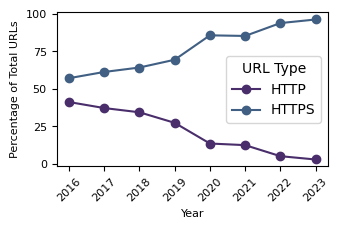

In [34]:
updated_poms_repos_df = all_poms_repos
updated_poms_repos_df['releaseYear'] = pd.to_datetime(updated_poms_repos_df['releaseDate']).dt.year

# Filtering data for the years 2015 to 2023
filtered_years_df = updated_poms_repos_df[(updated_poms_repos_df['releaseYear'] >= 2016) & (updated_poms_repos_df['releaseYear'] <= 2023)]

# Categorizing the URL type with the adjusted criteria, handling NaN or non-string values
filtered_years_df['url_type'] = filtered_years_df['url_repo'].apply(
    lambda x: 'https' if isinstance(x, str) and 'https://' in x else ('http' if isinstance(x, str) and 'http://' in x else 'other')
)

# Counting the usage of HTTP, HTTPS, and other URLs per year
http_https_other_counts = filtered_years_df.groupby(['releaseYear', 'url_type']).size().unstack(fill_value=0)

# Converting counts to percentages of the total for each year
http_https_other_percentages = http_https_other_counts.div(http_https_other_counts.sum(axis=1), axis=0) * 100

# Remove other from plot (these were urls that that did not mention http or https protocol)
http_https_other_percentages = http_https_other_percentages.drop(columns=['other'])

# Plotting
plt.figure(figsize=(3.5, 2))
plt.plot(http_https_other_percentages.index, http_https_other_percentages['http'], marker='o', color='#492e6b', label='HTTP')
plt.plot(http_https_other_percentages.index, http_https_other_percentages['https'], marker='o', color='#405f82', label='HTTPS')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Percentage of Total URLs', fontsize=8)
plt.xticks(http_https_other_percentages.index, rotation=45)
plt.legend(title='URL Type')
plt.show()

# Repository URL and Id Analysis

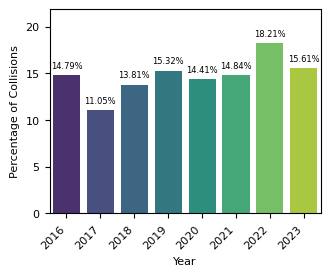

Correlation: 0.6405
p-value: 0.087


In [35]:
# Grouping by year and id_repo, counting unique URLs per id_repo
poms_repos_df = all_poms_repos
poms_repos_df['url_repo'] = poms_repos_df['url_repo'].str.rstrip('/')
poms_repos_df['releaseYear'] = pd.to_datetime(poms_repos_df['releaseDate']).dt.year
unique_urls_per_id_year = poms_repos_df.groupby(['releaseYear', 'id_repo'])['url_repo'].nunique()

# Finding the ids with at least two different urls (collisions)
collision_ids_per_year = unique_urls_per_id_year[unique_urls_per_id_year > 1]

# Counting total ids and collision ids per year
total_ids_per_year = poms_repos_df.groupby('releaseYear')['id_repo'].nunique()
collision_count_per_year = collision_ids_per_year.groupby(level=0).count()

# Calculating the percentage of ids with collisions per year
collision_percentage_per_year = (collision_count_per_year / total_ids_per_year) * 100

# Plotting
plt.figure(figsize=(3.5, 3))
plt.subplots_adjust(bottom=0.2)
bars = sns.barplot(x=collision_percentage_per_year.index, y=collision_percentage_per_year.values, palette='viridis')

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=6)
plt.ylim(0, 1.2 * max(collision_percentage_per_year.values))
plt.xticks(rotation=45, horizontalalignment='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Percentage of Collisions', fontsize=8)
plt.show()

correlation, p_value = pearsonr(collision_percentage_per_year.index, collision_percentage_per_year.values)
print(f'Correlation: {correlation:.4f}' + '\n' + f'p-value: {p_value:.3f}')

In [36]:
poms_repos_df = all_poms_repos.copy()
# Strip right of / and get unique urls
poms_repos_df['url_repo'] = poms_repos_df['url_repo'].str.rstrip('/')
# Group by 'url_repo' and calculate the number of unique 'id_repo' for each URL
unique_ids_per_url = poms_repos_df.groupby('url_repo')['id_repo'].nunique()

# Filter out the URLs that have only one unique 'id_repo' (i.e., no collisions)
url_collisions = unique_ids_per_url[unique_ids_per_url > 1]

print(f"Percentage of repositories with collisions: {(len(url_collisions) / len(poms_repos_df)) * 100:.2f}%")
print(f"Percentage of unique repository urls with collisions: {(len(url_collisions) / len(unique_ids_per_url)) * 100:.2f}%")

Percentage of repositories with collisions: 1.72%
Percentage of unique repository urls with collisions: 20.75%


In [37]:
poms_repos_df = all_poms_repos.copy()
# Strip right of / and get unique urls
poms_repos_df['url_repo'] = poms_repos_df['url_repo'].str.rstrip('/')
unique_urls_per_id = poms_repos_df.groupby('id_repo')['url_repo'].nunique()

id_collisions = unique_urls_per_id[unique_urls_per_id > 1]


print(f"Percentage of repositories with collisions: {(len(id_collisions) / len(poms_repos_df)) * 100:.2f}%")
print(f"Percentage of unique repository ids with collisions: {(len(id_collisions) / len(unique_urls_per_id)) * 100:.2f}%")

Percentage of repositories with collisions: 1.99%
Percentage of unique repository ids with collisions: 19.31%


In [20]:
poms_repos_df = all_poms_repos.copy()
# Removing trailing slashes from the urls
poms_repos_df['url_repo'] = poms_repos_df['url_repo'].str.rstrip('/')
# Group by 'url_repo' and calculate the number of unique 'id_repo' for each URL
unique_ids_per_url = poms_repos_df.groupby('url_repo')['id_repo'].nunique()

# Count the frequency of each URL
url_counts = poms_repos_df['url_repo'].value_counts()

# Convert the Series to a DataFrame
url_counts_df = url_counts.reset_index()

# Rename the columns
url_counts_df.columns = ['url_repo', 'frequency']

# Merge the DataFrame with the Series on 'url_repo'
result_df = pd.merge(url_counts_df, unique_ids_per_url, on='url_repo')

# Rename the columns
result_df.columns = ['url_repo', 'frequency', 'unique_ids']

result_df.head(10)

,url_repo,frequency,unique_ids
0,https://oss.sonatype.org/content/repositories/...,1760,97
1,https://jitpack.io,741,2
2,https://repo1.maven.org/maven2,649,26
3,https://build.shibboleth.net/nexus/content/rep...,539,7
4,https://oss.sonatype.org/content/repositories/...,469,39
5,https://jcenter.bintray.com,418,18
6,https://repo.spring.io/milestone,412,10
7,https://files.couchbase.com/maven2,388,2
8,https://repo.spring.io/snapshot,378,3
9,https://repo.maven.apache.org/maven2,352,18


In [21]:
average_unique_ids = result_df['unique_ids'].mean()
average_unique_ids

1.704235463029433

In [22]:
# Group by 'id_repo' and calculate the number of unique 'url_repo' for each id
unique_urls_per_id = poms_repos_df.groupby('id_repo')['url_repo'].nunique()

# Count the frequency of each id
id_counts = poms_repos_df['id_repo'].value_counts()

# Convert the Series to a DataFrame
id_counts_df = id_counts.reset_index()

# Rename the columns
id_counts_df.columns = ['id_repo', 'frequency']

# Merge the DataFrame with the Series on 'id_repo'
result_df = pd.merge(id_counts_df, unique_urls_per_id, on='id_repo')

# Rename the columns
result_df.columns = ['id_repo', 'frequency', 'unique_urls']

# Sort by 'frequency' in descending order and get the top 10 rows
result_df = result_df.sort_values(by='frequency', ascending=False).head(10)

result_df.head(10)

,id_repo,frequency,unique_urls
0,shib-release,576,3
1,jitpack,569,1
2,central,555,31
3,couchbase,550,2
4,maven-central,449,7
5,spring-milestones,444,8
6,sonatype-nexus-snapshots,440,11
7,jcenter,422,4
8,atlassian-public,351,5
9,spring-snapshots,347,6


In [23]:
average_unique_urls = result_df['unique_urls'].mean()
average_unique_urls

7.8